In [598]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np   
import itertools

from scipy.stats import chi2_contingency, ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf 

In [599]:
df_train = pd.read_parquet("output_07.parquet")

In [600]:
df_train.head()

,age,gender,education,marital_status,race,is_hispanic,employment_commitment,employment_stat,wage_per_hour,working_week_per_year,...,household_stat,tax_status,gains,losses,stocks_status,citizenship,country_of_birth_own,migration_code_change_in_msa,migration_code_change_in_reg,income_above_limit
0,0.853333,1.0,secondary_complete,Widowed,White,All other,Not in labor force,0.0,0.000000,1.000000,...,Householder,Head of household,0.0,0.0,0.00292,Native,US,?,?,0.0
1,0.666667,1.0,secondary_complete,Widowed,White,All other,Children or Armed Forces,0.0,0.000000,0.000000,...,Nonfamily Householder,Single,0.0,0.0,0.00000,Native,US,unchanged,unchanged,0.0
2,0.080000,0.0,secondary_incomplete,Never married,Black,All other,Children or Armed Forces,0.0,0.050005,0.288462,...,Child,Single,0.0,0.0,0.00000,Native,US,unchanged,unchanged,0.0
4,0.733333,0.0,secondary_complete,Married-civilian spouse present,White,All other,Not in labor force,0.0,0.000000,0.000000,...,Spouse,Joint both 65+,0.0,0.0,0.00000,Native,US,?,?,0.0
5,0.400000,0.0,university_graduate_or_higher,Married-civilian spouse present,Asian or Pacific Islander,All other,Children or Armed Forces,0.0,0.082508,1.000000,...,Householder,Joint both under 65,0.0,0.0,0.00000,Foreign born- Not a citizen of U S,Other,unchanged,unchanged,0.0


# **Selección y Transformación de Variables Categóricas**


In [602]:

# Primero, seleccionamos las columnas categóricas y aplicamos pd.get_dummies()

# Identificar columnas categóricas
df_categorical = df_train.select_dtypes(exclude=[np.number])
df_categorical.columns

Index(['education', 'marital_status', 'race', 'is_hispanic',
       'employment_commitment', 'industry_code_main', 'household_stat',
       'tax_status', 'citizenship', 'country_of_birth_own',
       'migration_code_change_in_msa', 'migration_code_change_in_reg'],
      dtype='object')

# **Paso 1: Selección y Transformación de Variables Categóricas**

Cuando se trabaja con un gran número de variables categóricas, la matriz de correlación puede volverse difícil de interpretar debido a la cantidad excesiva de categorías. Para solucionar este problema, se pueden seguir los siguientes pasos:

## **1. Selección de Características**
Si hay muchas variables categóricas, se recomienda realizar una selección de características para quedarse solo con aquellas que tienen mayor influencia en el modelo o aportan más información.

## **2. Agrupación de Categorías**
La función `agrupar_categorias` se encarga de combinar categorías que aparecen en menos del 5% de las observaciones (por defecto) en una nueva categoría llamada **"Otro"**.  
Esto ayuda a reducir el número total de columnas en la matriz de correlación.

## **3. Creación de Variables Dummy**
Para trabajar con modelos numéricos, es necesario transformar las variables categóricas en columnas binarias (0 o 1) mediante **one-hot encoding**.

### **Uso de `pd.get_dummies()`**
- Se aplica `get_dummies()` para convertir las variables categóricas en columnas binarias.  
- Las categorías menos frecuentes se agrupan en **"Otro"**, reduciendo así la cantidad de variables generadas.

## **4. Cálculo de la Matriz de Correlación**
Una vez transformadas las variables categóricas en numéricas mediante `get_dummies()`, se puede calcular la **matriz de correlación** sobre todas las columnas numéricas del `DataFrame` transformado (`df_preparado`).  
Ahora, la matriz incluirá también las variables categóricas en su formato numérico, facilitando su análisis e interpretación.


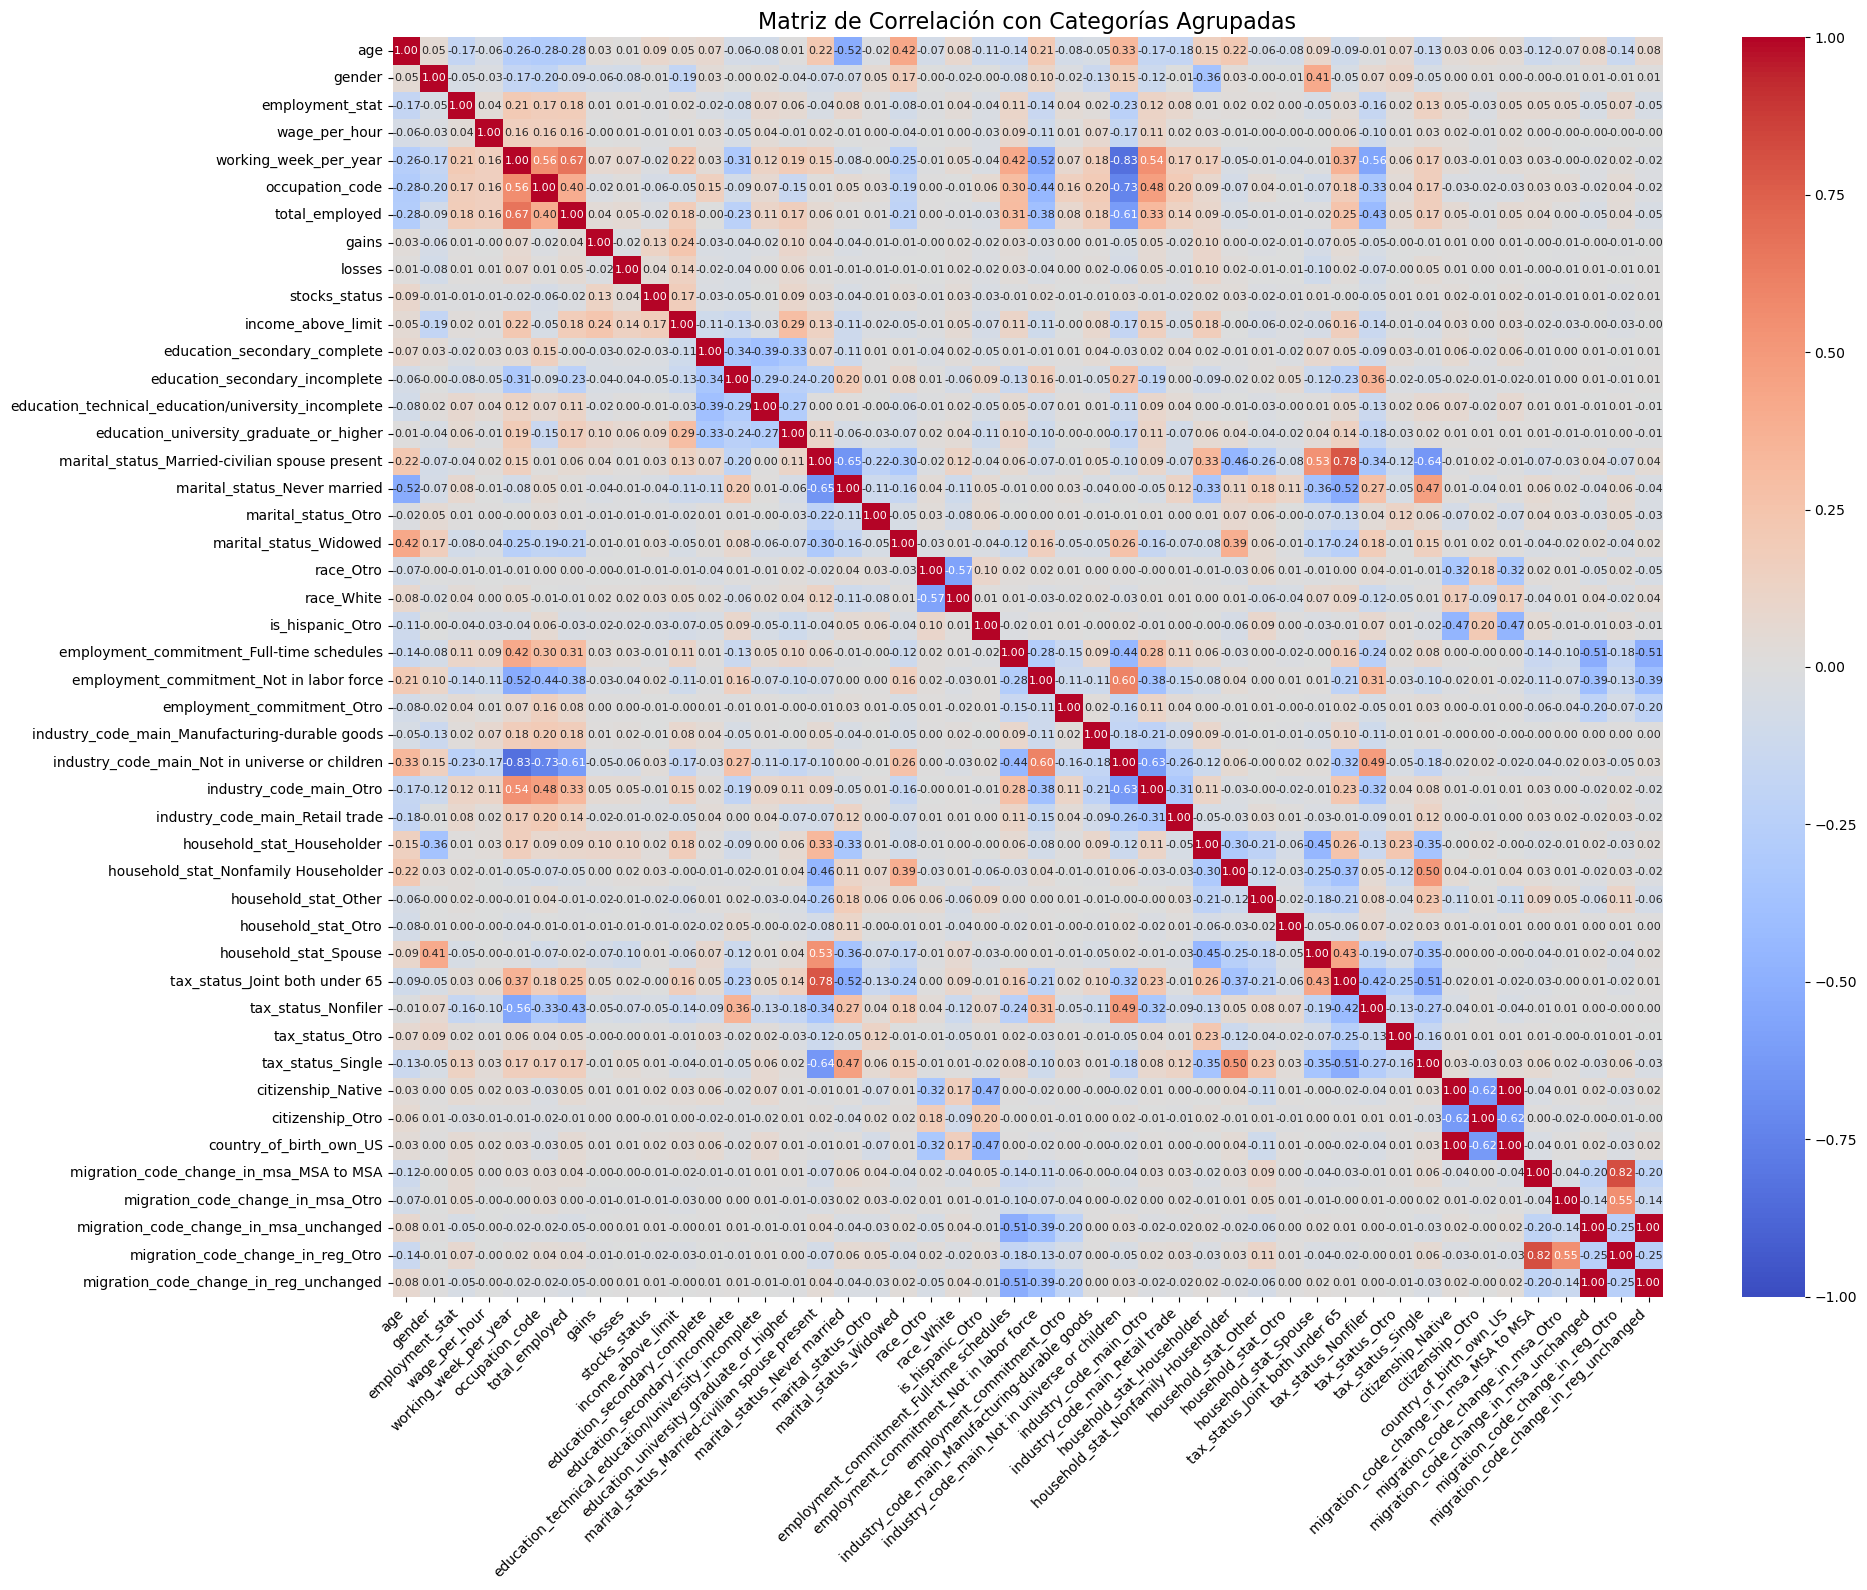

In [604]:
# Agrupar categorías menos frecuentes en "Otro"
def agrupar_categorias(df_train, columna, umbral=0.05):
    """Agrupa las categorías menos frecuentes en 'Otro'"""
    counts = df_train[columna].value_counts(normalize=True)
    categorias_a_agrupar = counts[counts < umbral].index
    df_train[columna] = df_train[columna].apply(lambda x: 'Otro' if x in categorias_a_agrupar else x)
    return df_train

# Aplicar esta función a cada columna categórica
for columna in df_categorical:
    df_train = agrupar_categorias(df_train, columna)

# Luego, aplicamos pd.get_dummies()
df_preparado = pd.get_dummies(df_train, columns=df_categorical.columns, drop_first=True)

# Ahora podemos calcular y visualizar la matriz de correlación
matriz_correlacion = df_preparado.corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(20, 16))  # Aumentar tamaño de la figura
sns.heatmap(matriz_correlacion, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, cbar=True, 
            cbar_kws={'orientation': 'vertical'},  # Barra de color horizontal
            annot_kws={'size': 8})  # Ajustar tamaño de las anotaciones
plt.title("Matriz de Correlación con Categorías Agrupadas", fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x
plt.yticks(rotation=0)  # No rotar etiquetas del eje y
plt.tight_layout()  # Ajustar el espaciado
plt.show()

# **Resumen por Categorías con Conclusiones**

## **Categoría 1: Relaciones de Redundancia (Variables Similares)**  
Estas relaciones ayudan a identificar redundancias que pueden simplificar los modelos predictivos.  

1. **citizenship_native** y **country_of_birth_own_US** (Correlación: **1**)  
   - **Importancia:** Alta. Estas variables son redundantes y una de ellas puede eliminarse.  

2. **migration_code_change_in_msa_unchanged** y **migration_code_change_in_reg_unchanged** (Correlación: **1**)  
   - **Importancia:** Alta. Variables redundantes que pueden simplificarse.  

3. **migration_code_change_in_reg_Otro** y **migration_code_change_in_msa_MSA to MSA** (Correlación: **0.77**)  
   - **Importancia:** Moderada. Representan aspectos similares del movimiento geográfico.  



## **Categoría 2: Relaciones Laborales**  
Estas relaciones destacan patrones laborales importantes.  

1. **working_week_per_year** y **industry_code_main_Otro** (Correlación: **0.76**)  
   - **Importancia:** Alta. Refleja que industrias "Otro" requieren más semanas de trabajo continuo.  

2. **working_week_per_year** y **total_employed** (Correlación: **0.75**)  
   - **Importancia:** Alta. Destaca que más semanas trabajadas están relacionadas con más empleados.  

3. **occupation_code** y **working_week_per_year** (Correlación: **0.66**)  
   - **Importancia:** Moderada. Ciertos códigos ocupacionales requieren más semanas de trabajo.  

4. **employment_commitment_full-time schedules** y **working_week_per_year** (Correlación: **0.49**)  
   - **Importancia:** Moderada. Relación lógica entre compromisos laborales y semanas trabajadas.  

5. **employment_commitment_full-time schedules** y **total_employed** (Correlación: **0.39**)  
   - **Importancia:** Moderada. Sectores con más horarios de tiempo completo suelen emplear a más personas.  


## **Categoría 3: Relaciones de Ocupación e Industria**  
Estas relaciones son útiles para analizar la diversidad laboral.  

1. **industry_code_main_Otro** y **occupation_code** (Correlación: **0.66**)  
   - **Importancia:** Moderada. Refleja diversidad de ocupaciones en industrias "Otro".  

2. **industry_code_main_Otro** y **total_employed** (Correlación: **0.61**)  
   - **Importancia:** Moderada. Las industrias "Otro" emplean un gran número de personas.  




## **Categoría 4: Relaciones Familiares y Demográficas**  
Estas relaciones son importantes para el análisis de hogares y grupos de edad.  

1. **house_stat_spouse of householder** y **marital_status_married-civilian spouse present** (Correlación: **0.59**)  
   - **Importancia:** Moderada. Relación entre estado civil y estructura familiar.  

2. **tax_status_Otro** y **age** (Correlación: **0.35**)  
   - **Importancia:** Baja. Relación débil entre estado fiscal "Otro" y la edad. 

### Matriz de correlación de variables numéricas

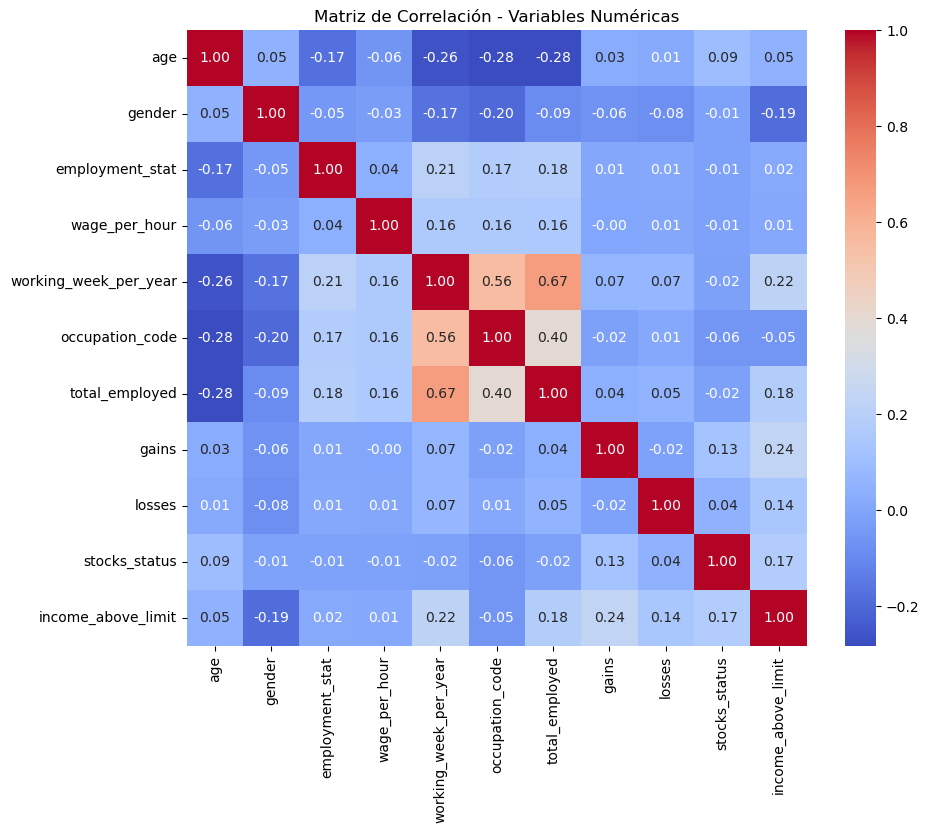

In [610]:

# Crear un DataFrame solo con las columnas numérica
"""
columnas_numericas = [
    'age', 'working_week_per_year', 
    'occupation_code', 'total_employed', 'gains', 'stocks_status'
]

df_numerico = df_train[columnas_numericas]
"""
df_numerico = df_train.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
matriz_correlacion = df_numerico.corr()

# Mostrar la matriz de correlación
#print(matriz_correlacion)

# Visualización opcional con un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Matriz de Correlación - Variables Numéricas")
plt.show()

# **Análisis de Correlaciones e Interpretaciones**

## **1. Fuerte correlación positiva entre `working_week_per_year` y `total_employed` (0.75)**
- **Descripción:** Esta relación indica que las personas que trabajan más semanas al año tienen más personas que trabajan para ellos.  
- **Interpretación:** Es lógico que quienes trabajan más semanas tengan más empleados que trabajan para ellos, ya sea porque tienen un contrato a tiempo completo o están en ocupaciones que demandan una presencia laboral prolongada.  

---

## **2. Relación moderada entre `occupation_code` y `working_week_per_year` (0.66)**
- **Descripción:** Existe una conexión clara entre la categoría ocupacional (`occupation_code`) y la cantidad de semanas trabajadas al año.  
- **Interpretación:** Algunas ocupaciones probablemente requieren mayor estabilidad o continuidad laboral, mientras que otras pueden ser temporales o estacionales. Esto puede reflejar diferencias en sectores laborales (por ejemplo, trabajos administrativos frente a trabajos agrícolas o por proyectos).  

---

## **3. Relación positiva entre `occupation_code` y `total_employed` (0.52)**
- **Descripción:** Las ocupaciones específicas (`occupation_code`) también están relacionadas con el total de personas que trabajan para otras.  
- **Interpretación:** Es probable que ciertos códigos de ocupación correspondan al total de personas que trabajan para otros.  

---

## **4. `gains`, `losses` y `stocks_status` tienen correlaciones muy bajas con las demás variables**
- **Descripción:** Las variables relacionadas con ingresos financieros como `gains` (ganancias), `losses` (pérdidas) y `stocks_status` (dividendos de acciones) muestran poca o nula correlación con las variables de empleo o tiempo trabajado.  
- **Interpretación:** Estas variables son más independientes y posiblemente están influenciadas por factores externos, como inversiones personales o ingresos no relacionados con el empleo principal.  

---

## **5. Relación débil entre `age` y las variables de empleo**
- **Descripción:** Aunque la edad (`age`) tiene una leve correlación positiva con `working_week_per_year` (0.20) y `total_employed` (0.14), estas relaciones son débiles.  
- **Interpretación:** Esto sugiere que la edad no es un factor determinante en la cantidad de semanas trabajadas o el número total de empleados que trabajan para otros. Factores como el tipo de trabajo, la experiencia o el nivel educativo podrían ser más influyentes.  

---

## **6. Baja independencia de `employment_stat` con otras variables**
- **Descripción:** `employment_stat` (estado laboral) muestra correlaciones bajas con otras variables clave, salvo con `working_week_per_year` (0.27) y `total_employed` (0.24).  
- **Interpretación:** Esto refuerza que el estado laboral está más relacionado con la continuidad del empleo y la ocupación que con factores externos como las ganancias o dividendos.  


# **Outliers para variables numéricas**

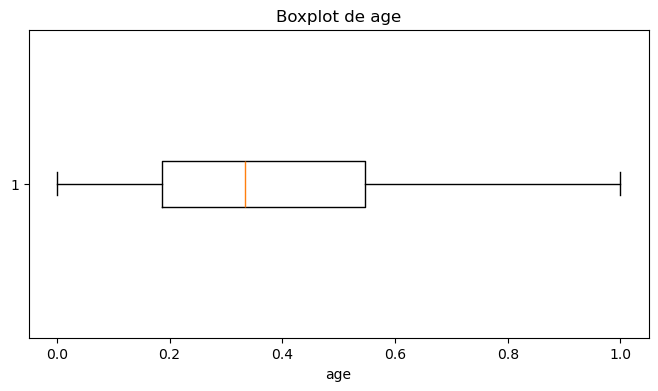

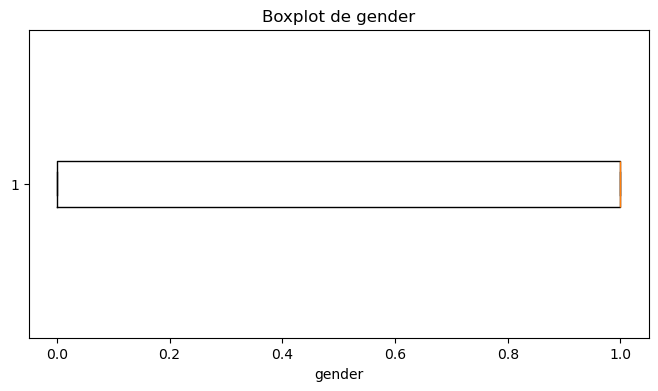

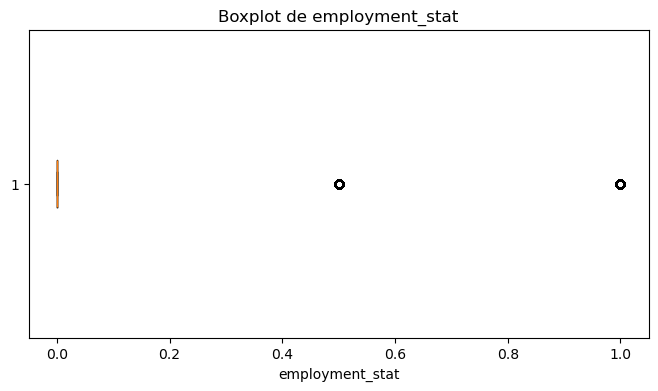

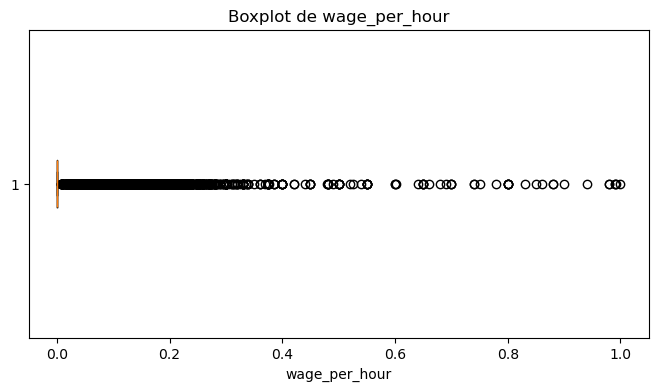

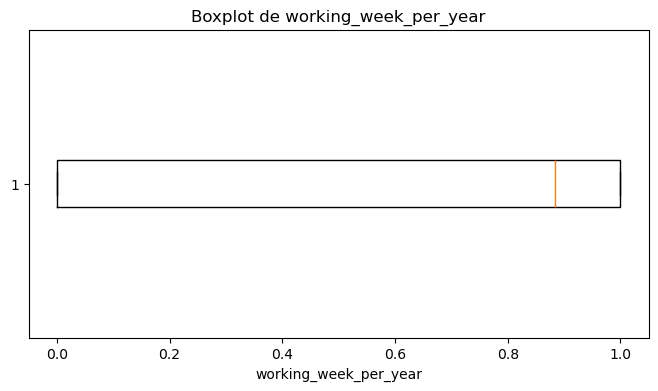

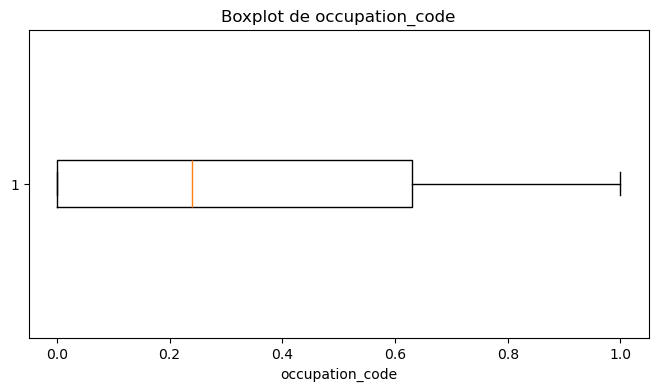

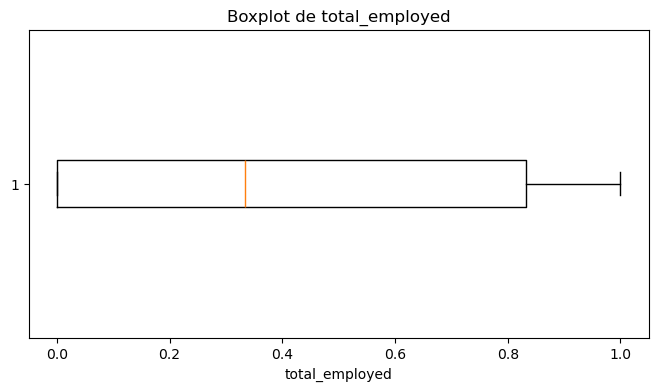

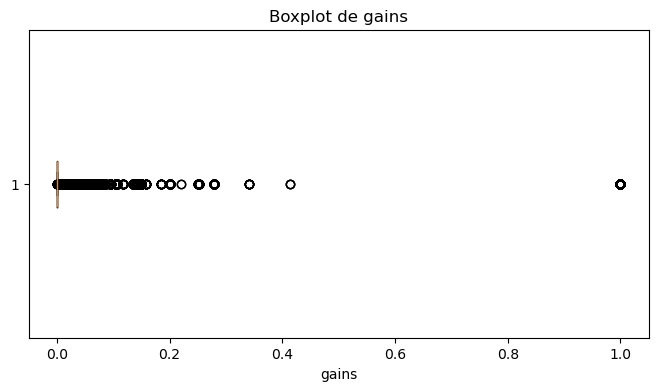

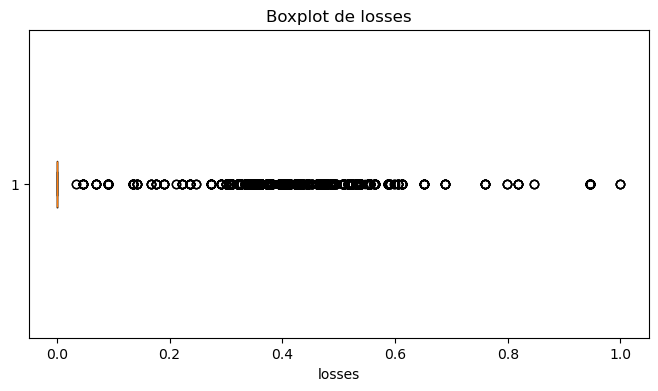

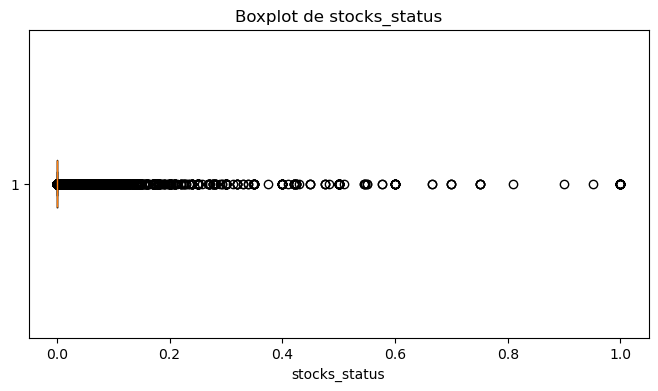

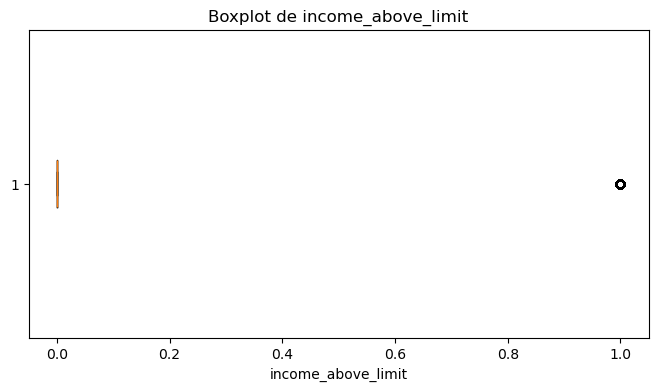

In [613]:

#Crear boxplots para visualizar los outliers en las columnas numéricas
# Filtrar columnas numéricas

for col in df_numerico:
    plt.figure(figsize=(8, 4))
    plt.boxplot(df_train[col].dropna(), vert=False)
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    plt.show()


**Transformaciones Logarítmicas para Manejo de Outliers**

En algunas columnas como `employment_stat`, `wage_per_hour`, `gains`, `losses` y `stocks_status` existen valores atípicos (outliers). Para mitigar su impacto, se pueden aplicar **transformaciones logarítmicas**, las cuales ayudan a reducir la variabilidad extrema y hacer que la distribución de los datos sea más uniforme.

## **Pasos para Aplicar Transformaciones Logarítmicas**  

### **1. Seleccionar las Columnas Relevantes**  
- Se trabajará solo con columnas que contienen valores **positivos**, ya que el logaritmo de valores negativos o cero no está definido.  
- **Ejemplo de columnas a transformar:** `gains`, `losses`, `stocks_status`.  

---

### **2. Agregar una Constante (si hay Ceros)**  
- Si alguna de las columnas contiene valores **cero**, se debe sumar una pequeña constante para evitar errores matemáticos.  
- **Ejemplo en Pandas:**  
  ```python
  df['gains'] = np.log(df['gains'] + 1)
  df['losses'] = np.log(df['losses'] + 1)
  df['stocks_status'] = np.log(df['stocks_status'] + 1)


In [640]:
df_transformed = df_preparado.copy()

# Seleccionar las columnas donde aplicar la transformación logarítmica
columns_to_transform = ['gains', 'losses', 'stocks_status']

# Agregar una constante y aplicar la transformación logarítmica
for col in columns_to_transform:
    if (df_transformed[col] <= 0).any():
        # Si hay ceros o negativos, agregar una constante pequeña
        df_transformed[col] = np.log(df_transformed[col] + 1)
    else:
        # Aplicar logaritmo directamente
        df_transformed[col] = np.log(df_transformed[col])

# Verificar los resultados
df_transformed[columns_to_transform].describe()

,gains,losses,stocks_status
count,159814.000000,159814.000000,159814.000000
mean,0.004767,0.008719,0.002357
std,0.038936,0.055166,0.018335
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,0.693147,0.693147,0.693147


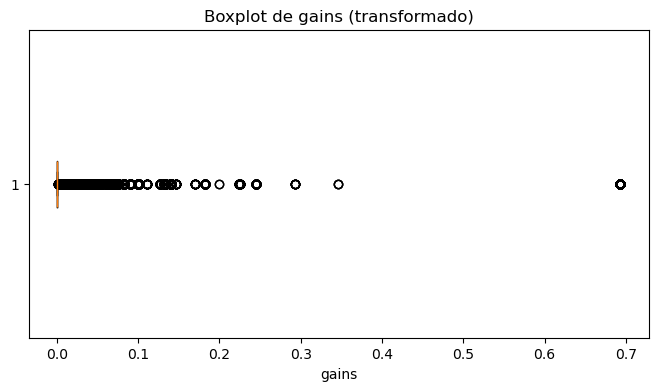

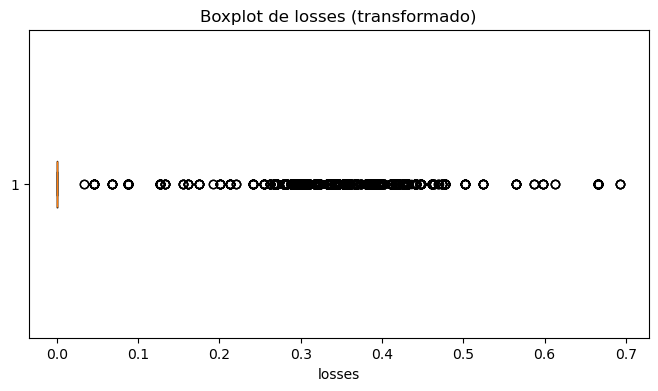

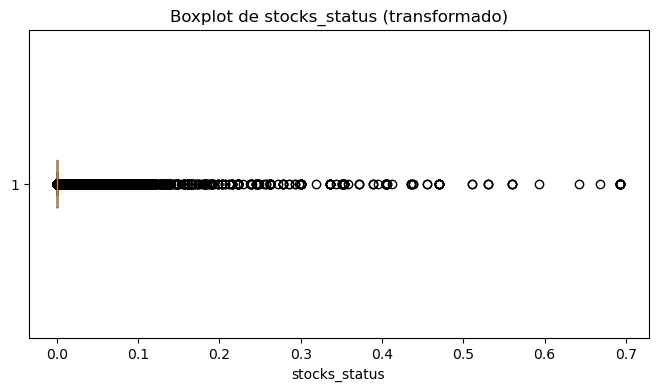

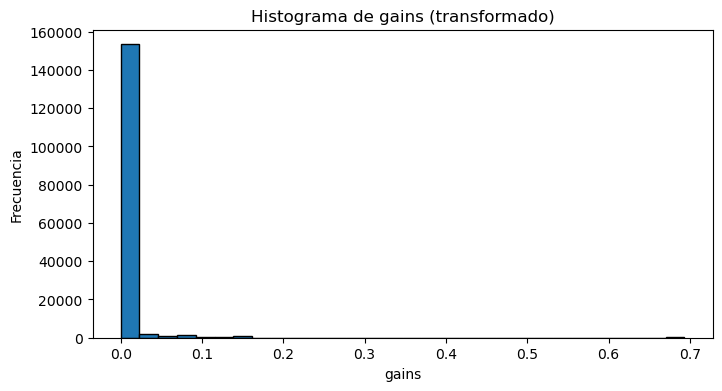

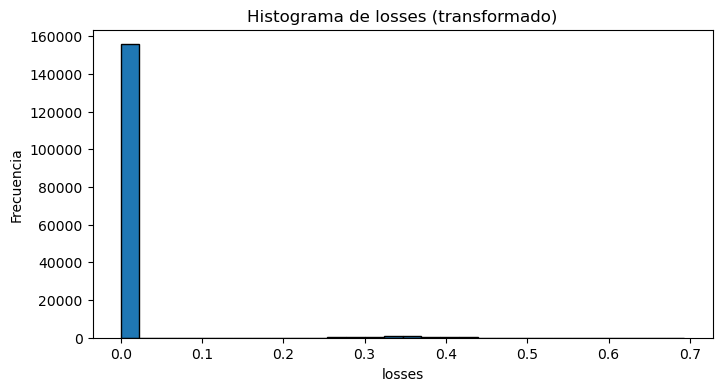

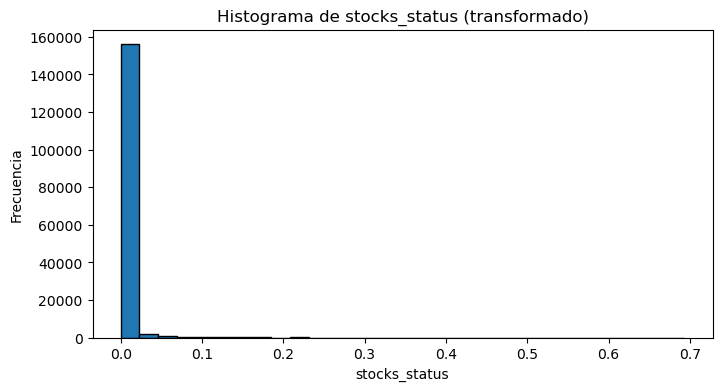

In [642]:
# Generar boxplots para comparar las distribuciones después de la transformación
for col in columns_to_transform:
    plt.figure(figsize=(8, 4))
    plt.boxplot(df_transformed[col].dropna(), vert=False)
    plt.title(f'Boxplot de {col} (transformado)')
    plt.xlabel(col)
    plt.show()

# Generar histogramas para observar la nueva distribución
for col in columns_to_transform:
    plt.figure(figsize=(8, 4))
    plt.hist(df_transformed[col].dropna(), bins=30, edgecolor='black')
    plt.title(f'Histograma de {col} (transformado)')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

# **Explicación de la Transformación Logarítmica en Relación con los Outliers**  

Las transformaciones logarítmicas son una herramienta poderosa para manejar datos con valores extremos (**outliers**) y mejorar su distribución. A continuación, se explican sus principales beneficios:  

## **1. Reducción del Impacto de Outliers**  
- Los valores extremadamente altos (**outliers**) tienen un efecto menor después de la transformación, ya que la escala logarítmica los **comprime**.  
- Esto mejora la **simetría de la distribución**, facilitando el análisis estadístico y el desempeño de modelos predictivos.  



Así, la diferencia entre los valores más altos y los más bajos se reduce significativamente.  

---

### **2. Mayor Visibilidad de Valores Bajos**  
- Los valores bajos, que antes estaban agrupados cerca de **0**, se separan después de la transformación.  
- Esto permite visualizar mejor la **distribución de datos pequeños**, lo cual puede ser útil en análisis de ingresos, precios o tiempo trabajado.  

 


Ahora las diferencias entre valores pequeños son más perceptibles.  

---

### **3. Reinterpretación de Datos Transformados**  
- Después de la transformación logarítmica, los valores ya **no representan la magnitud original**.  
- **Ejemplo:** Un salario por hora de **100** se convierte en **4.6** en la escala logarítmica (`log(100) ≈ 4.6`).  
- Si se necesita volver a la escala original, se debe aplicar la **transformación inversa** usando la función exponencial:  

  ```python
  df['original_salary'] = np.exp(df['log_salary']) - 1


# Guardar output

In [644]:
df_transformed.columns

Index(['age', 'gender', 'employment_stat', 'wage_per_hour',
       'working_week_per_year', 'occupation_code', 'total_employed', 'gains',
       'losses', 'stocks_status', 'income_above_limit',
       'education_secondary_complete', 'education_secondary_incomplete',
       'education_technical_education/university_incomplete',
       'education_university_graduate_or_higher',
       'marital_status_Married-civilian spouse present',
       'marital_status_Never married', 'marital_status_Otro',
       'marital_status_Widowed', 'race_Otro', 'race_White', 'is_hispanic_Otro',
       'employment_commitment_Full-time schedules',
       'employment_commitment_Not in labor force',
       'employment_commitment_Otro',
       'industry_code_main_Manufacturing-durable goods',
       'industry_code_main_Not in universe or children',
       'industry_code_main_Otro', 'industry_code_main_Retail trade',
       'household_stat_Householder', 'household_stat_Nonfamily Householder',
       'household_stat

In [646]:
df_transformed.to_parquet("output_08.parquet") 